# Simulated Actuations

This notebook takes detector actuations from hi-res data and converts them into detector group state integers per NTCIP 1202 v3 section 5.3.11.3 (page 275). Those state integers are then used to replace the actuations in the hi-res data by feeding them into test controllers. 

First, retreive the data.

In [1]:
import pandas as pd
import duckdb
from sqlalchemy import create_engine
import warnings

def query_mssql(query, server, database):
    query = "SET NOCOUNT ON; " + query
    connection_string = f"mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver=SQL+Server"
    engine = create_engine(connection_string)
    conn = engine.raw_connection() # Uses DBAPI
    # Supress warning from Pandas where it says it's only tested on sqlalchemy
    # This method is MUCH faster, so I'll stick with it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.read_sql_query(query, conn)
    conn.close()
    engine.dispose()
    return df

sql = """
SELECT TimeStamp, DeviceId, EventId, Parameter as Detector,
    CASE WHEN EventId IN(81,82) THEN 'Vehicle'
        WHEN EventId IN(104,102) THEN 'Preempt'
        WHEN EventId IN(89,90) THEN 'Ped'
        END as DetectorType
FROM ASCEvents
WHERE EventId IN(81,82, 104,102, 89,90) --OFF/ON for vehicle detector, preempt, ped detector
    AND DeviceId IN(507,503)
    AND Parameter < 50 --remove dummy detectors
    AND TimeStamp >= '2024-01-09 09:00:00.000'
    AND TimeStamp < '2024-01-09 12:00:00.000'
    
ORDER BY TimeStamp
"""
raw_data = query_mssql(sql, 'SP2SQLMAX101', 'MaxView_EventLog')
raw_data

,TimeStamp,DeviceId,EventId,Detector,DetectorType
0,2024-01-09 09:00:00.200,507,82,2,Vehicle
1,2024-01-09 09:00:00.200,507,82,3,Vehicle
2,2024-01-09 09:00:00.500,503,82,16,Vehicle
3,2024-01-09 09:00:00.600,507,81,2,Vehicle
4,2024-01-09 09:00:00.600,507,81,16,Vehicle
...,...,...,...,...,...
33600,2024-01-09 11:59:57.600,507,82,17,Vehicle
33601,2024-01-09 11:59:58.000,507,81,17,Vehicle
33602,2024-01-09 11:59:58.300,503,82,8,Vehicle
33603,2024-01-09 11:59:59.000,503,81,8,Vehicle


The next step is to impute actuations. This is needed because there may be two in a row on or off events, either due to missing data, or because extension time can cause two in a row detector on events to be registered. In order to track the state integer of all detectors, there an off must always be followed by an on, and vice versa. Also, the first event must be an on event, to avoid negative numbers.

In [2]:
sql = """
-- impute_actuations
/* 
This is to fill in missing detector on/off events through interpolation
Sometimes detector on events (82) occur in rapic succession without an off event separating them,
    When the gap between two-in-a-row ON events is <= 2000 milliseconds,
    add an OFF event with timestamp matching the next ON event.
If for two-in-a-row ON events more than 2000 milliseconds apart, an OFF event is added half-way between them
For two-in-a-row OFF events, an ON event is added half-way between them regardless of the gap size
*/
WITH lagged as (
    SELECT *,
        LAG(EventId) OVER (PARTITION BY DeviceId, Detector, DetectorType ORDER BY TimeStamp) as PrevEventId,
        datediff('MILLISECOND', LAG(TimeStamp) OVER (PARTITION BY DeviceId, Detector, DetectorType ORDER BY TimeStamp), TimeStamp) AS PrevDiff
    FROM raw_data
),
--INTERPOLATION FOR VEHICLE DETECTORS
interpolate_OFFS_rapid AS (
    SELECT TimeStamp, DeviceId, 81 AS EventId, Detector, DetectorType
    FROM lagged
    WHERE PrevDiff <= 2000
        and EventId = 82
        and PrevEventId = 82
),
interpolate_OFFs as (
    SELECT
        "TimeStamp" - INTERVAL (PrevDiff / 2) MILLISECOND as TimeStamp,
        DeviceId,
        81 as EventId,
        Detector, DetectorType
    FROM lagged
    WHERE PrevDiff > 2000
        and EventId = 82
        and PrevEventId = 82
),
interpolate_ONs AS (
    SELECT "TimeStamp" - INTERVAL (PrevDiff / 2) MILLISECOND as TimeStamp,
        DeviceId,
        82 AS EventId,
        Detector, DetectorType
    FROM lagged
    WHERE EventId = 81 AND PrevEventId = 81
),
--INTERPOLATION FOR PED DETECTORS
interpolate_PED_OFFS AS (
    SELECT "TimeStamp" - INTERVAL (PrevDiff / 2) MILLISECOND as TimeStamp,
        DeviceId,
        89 AS EventId,
        Detector, DetectorType
    FROM lagged
    WHERE EventId = 90 AND PrevEventId = 90
),
interpolate_PED_ONs AS (
    SELECT "TimeStamp" - INTERVAL (PrevDiff / 2) MILLISECOND as TimeStamp,
        DeviceId,
        90 AS EventId,
        Detector, DetectorType
    FROM lagged
    WHERE EventId = 89 AND PrevEventId = 89
),



combined AS (
    SELECT * FROM raw_data
    UNION ALL
    SELECT * FROM interpolate_OFFS_rapid
    UNION ALL
    SELECT * FROM interpolate_OFFs
    UNION ALL
    SELECT * FROM interpolate_ONs
    UNION ALL
    SELECT * FROM interpolate_PED_OFFS
    UNION ALL
    SELECT * FROM interpolate_PED_ONs
),
--Now remove first row if it is an OFF event
ordered_rows AS (
    SELECT *,
        ROW_NUMBER() OVER(PARTITION BY DeviceId, Detector, DetectorType ORDER BY TimeStamp) as row_num
    FROM combined
)
SELECT TimeStamp,
    DeviceId,
    EventId,
    Detector, DetectorType
FROM ordered_rows
WHERE NOT (row_num = 1 AND EventId IN(81, 89))
ORDER BY TimeStamp;
"""

imputed = duckdb.query(sql).df()
imputed.to_parquet('test_data.parquet', index=False)
imputed

,TimeStamp,DeviceId,EventId,Detector,DetectorType
0,2024-01-09 09:00:00.200,507,82,2,Vehicle
1,2024-01-09 09:00:00.200,507,82,3,Vehicle
2,2024-01-09 09:00:00.500,503,82,16,Vehicle
3,2024-01-09 09:00:00.600,507,81,2,Vehicle
4,2024-01-09 09:00:00.700,507,81,3,Vehicle
...,...,...,...,...,...
33760,2024-01-09 11:59:57.600,507,82,17,Vehicle
33761,2024-01-09 11:59:58.000,507,81,17,Vehicle
33762,2024-01-09 11:59:58.300,503,82,8,Vehicle
33763,2024-01-09 11:59:59.000,503,81,8,Vehicle


Now, to track the integer states of the detectors. 

In [3]:
sql = """
WITH DetectorEvents AS (
    SELECT
        TimeStamp,
        DeviceId,
        Detector,
        EventId, DetectorType,
        ((Detector - 1) // 8)::INT + 1 AS group_number, -- This calculates the group number
        CASE WHEN EventId IN(82,90) THEN POW(2, (Detector - 1) % 8)
                WHEN EventId IN(81,89) THEN -POW(2, (Detector - 1) % 8)
                ELSE 0 END AS value_change
    FROM imputed
),
CumulativeState AS (
    SELECT
        TimeStamp,
        DeviceId,
        Detector,
        EventId, DetectorType,
        group_number,
        SUM(value_change) OVER (PARTITION BY DeviceId, group_number, DetectorType ORDER BY TimeStamp, Detector)::INT AS state_integer
    FROM DetectorEvents
),
--Now deal with preempt events
PreemptEvents AS (
    SELECT
        TimeStamp,
        DeviceId,
        Detector,
        EventId, DetectorType,
        --The detector number is the group number for preempt events
        CASE WHEN EventID IN(104,102) THEN Detector
            ELSE group_number END AS group_number,
        CASE WHEN EventId = 102 THEN 1
            WHEN EventId = 104 THEN 0
            ELSE state_integer END AS state_integer
    FROM CumulativeState
),

RankedEvents AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY TimeStamp, DeviceId, group_number, DetectorType ORDER BY Detector DESC) AS rn
    FROM PreemptEvents
)
SELECT
    TimeStamp,
    COALESCE(EXTRACT(EPOCH FROM (TimeStamp - LAG(TimeStamp) OVER (ORDER BY TimeStamp))), 0) AS sleep_time,
    DeviceId,
    group_number,
    DetectorType,
    state_integer
FROM
    RankedEvents
WHERE
    rn = 1
ORDER BY
    TimeStamp, DeviceId, group_number;

"""
activation_feed = duckdb.query(sql).df()
activation_feed

,TimeStamp,sleep_time,DeviceId,group_number,DetectorType,state_integer
0,2024-01-09 09:00:00.200,0.0,507,1,Vehicle,6
1,2024-01-09 09:00:00.500,0.3,503,2,Vehicle,128
2,2024-01-09 09:00:00.600,0.1,507,1,Vehicle,4
3,2024-01-09 09:00:00.700,0.1,507,1,Vehicle,0
4,2024-01-09 09:00:01.000,0.3,503,2,Vehicle,0
...,...,...,...,...,...,...
33084,2024-01-09 11:59:57.600,0.5,507,3,Vehicle,97
33085,2024-01-09 11:59:58.000,0.4,507,3,Vehicle,96
33086,2024-01-09 11:59:58.300,0.3,503,1,Vehicle,128
33087,2024-01-09 11:59:59.000,0.7,503,1,Vehicle,0


In [4]:
# add column for overal sleep time, which is a cumulative sum of sleep_time
activation_feed['sleep_time_cumulative'] = activation_feed['sleep_time'].cumsum()
activation_feed

,TimeStamp,sleep_time,DeviceId,group_number,DetectorType,state_integer,sleep_time_cumulative
0,2024-01-09 09:00:00.200,0.0,507,1,Vehicle,6,0.0
1,2024-01-09 09:00:00.500,0.3,503,2,Vehicle,128,0.3
2,2024-01-09 09:00:00.600,0.1,507,1,Vehicle,4,0.4
3,2024-01-09 09:00:00.700,0.1,507,1,Vehicle,0,0.5
4,2024-01-09 09:00:01.000,0.3,503,2,Vehicle,0,0.8
...,...,...,...,...,...,...,...
33084,2024-01-09 11:59:57.600,0.5,507,3,Vehicle,97,10797.4
33085,2024-01-09 11:59:58.000,0.4,507,3,Vehicle,96,10797.8
33086,2024-01-09 11:59:58.300,0.3,503,1,Vehicle,128,10798.1
33087,2024-01-09 11:59:59.000,0.7,503,1,Vehicle,0,10798.8


# Send Detector State Commands to Controllers

First define a function that will send the NTCIP commands. 

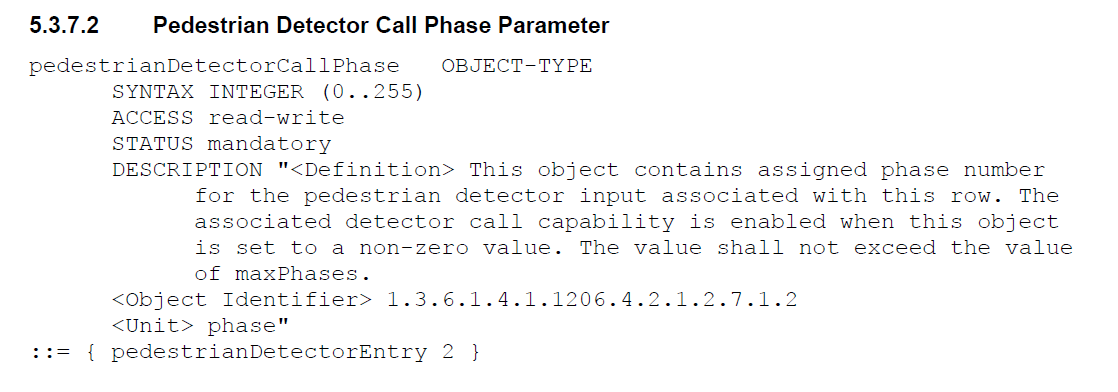

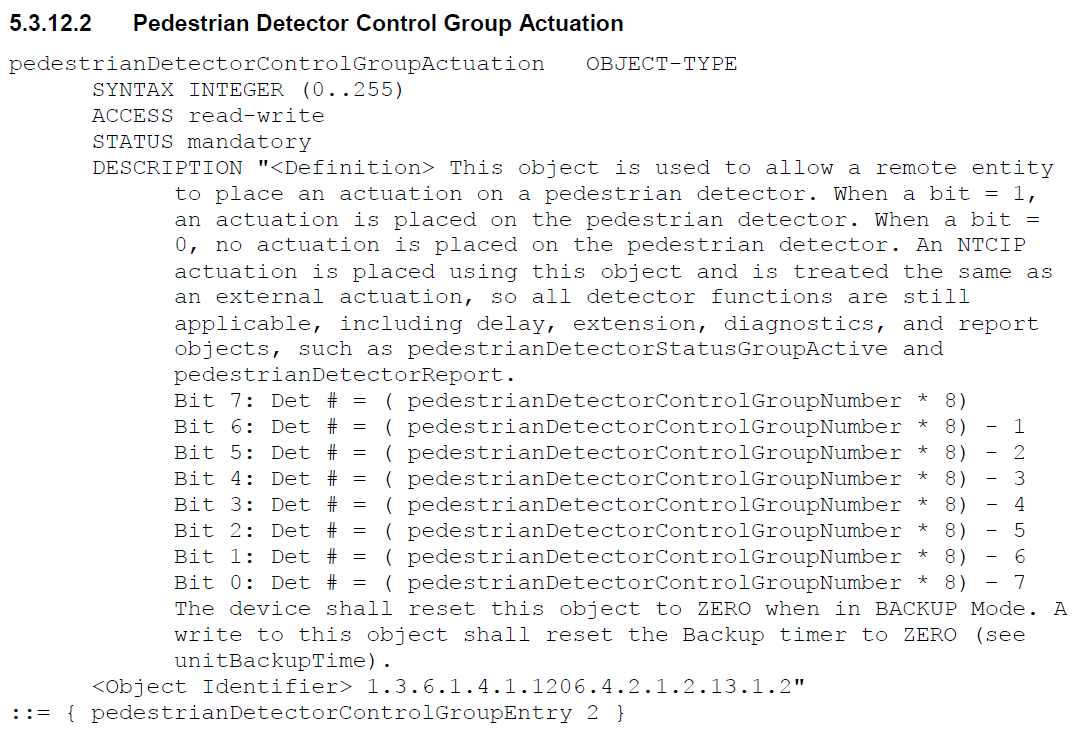

In [40]:
from pysnmp.hlapi import *
import time

# This function will set the state of a vehicle detector group
def send_data(ip_port, detector_group, state_integer, type):
    try:
        # From NTCIP 1202 v3 section 5.3.11.3 - Vehicle Detector Control Group Actuation
        if type == 'Vehicle':
            oid = ObjectIdentity(f'1.3.6.1.4.1.1206.4.2.1.2.12.1.2.{detector_group}')
        elif type == 'Ped':
            oid = ObjectIdentity(f'1.3.6.1.4.1.1206.4.2.1.2.13.1.2.{detector_group}')
        elif type == 'Preempt':
            oid = ObjectIdentity(f'1.3.6.1.4.1.1206.4.2.1.6.3.1.2.{detector_group}') 

        error_indication, error_status, error_index, var_binds = next(
            setCmd(
                SnmpEngine(),
                CommunityData('public', mpModel=0),
                UdpTransportTarget(ip_port),
                ContextData(),
                ObjectType(oid, Integer(state_integer))
            )
        )

        if error_indication:
            print(f"Error at {time.ctime()}: {error_indication}")
        elif error_status:
            print(f"Error at {time.ctime()} at {error_index}: {error_status.prettyPrint()}")

    except Exception as e:
        print(f"An exception occurred: {e}")

In [44]:
# read ip_mapping.txt into a dictionary (contains the DeviceId, IP address, and port)
ip_mapping = {}
with open('ip_mapping.txt') as f:
    for line in f:
        (device, ip, port) = line.split(',')
        ip_mapping[int(device)] = (ip, int(port))

In [45]:
ip_mapping

{507: ('127.0.0.1', 443), 503: ('127.0.0.1', 444)}

In [47]:
import threading
import time

# wait until the start time of 9:00:00
start_time = pd.Timestamp('2024-01-17 12:29:50.000')
while pd.Timestamp.now() < start_time:
    time.sleep(5)
start_time = pd.Timestamp('2024-01-17 12:30:00.200')
while pd.Timestamp.now() < start_time:
    time.sleep(0.01)

start_time = time.time()

for index, row in activation_feed.iterrows():

    # Sleep if necessary
    delta = time.time() - start_time
    if delta < row.sleep_time_cumulative:
        time.sleep(row.sleep_time_cumulative - delta)

    # Send the command in a separate thread
    threading.Thread(target=send_data, args=(ip_mapping[row.DeviceId], row.group_number, row.state_integer, row.DetectorType)).start()